# **CLASE 6: Clasifición binaria (Árbol de decisión).**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
ruta_archivo = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(ruta_archivo)

## **Preprocesamiento**
Esta vez solo utilizamosdos variables numéricas por simplicidad

In [3]:
X = df[['MonthlyCharges','TotalCharges']]
y = df['Churn']
# Convertimos a numérico forzando errores a NaN (por si hay espacios en blanco)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X['TotalCharges'] = X['TotalCharges'].fillna(X['TotalCharges'].mean())
# Convertimos a binaria
y = df['Churn'].map({'Yes': 1, 'No': 0})
# 5. DIVISIÓN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## **ENTRENAMIENTO DEL ÁRBOL**
Usamos max_depth=3 para mantener la Parsimonia (un árbol legible)

In [4]:
modelo_tree = DecisionTreeClassifier(max_depth=3, random_state=42, criterion='entropy')
modelo_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

## **VISUALIZACIÓN ESTRATÉGICA**

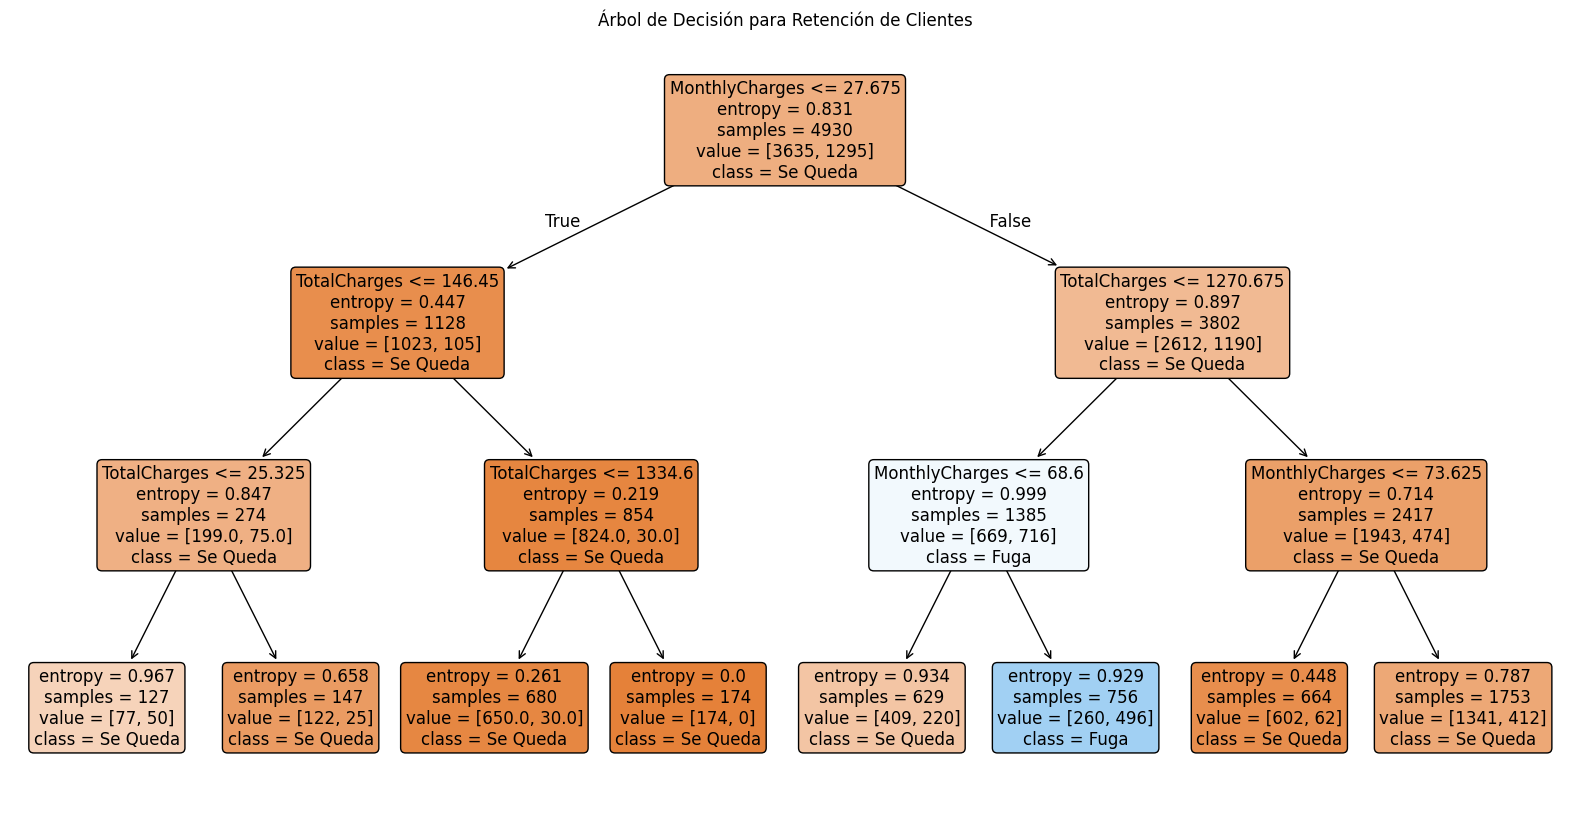

In [5]:
plt.figure(figsize=(20,10))
plot_tree(modelo_tree,
          feature_names=X.columns,
          class_names=['Se Queda', 'Fuga'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.title("Árbol de Decisión para Retención de Clientes")
plt.show()

## **Guía rápida para leer el gráfico:**
Color Intenso: Entropía baja (Nodos puros). Son nuestras reglas de negocio más sólidas.

Color Tenue/Blanco: Entropía alta (Mezcla). Son segmentos donde todavía no sabemos con certeza qué hará el cliente.

💡 Consejo de Negocio: Un nodo con entropía 0 y 100 clientes es una segmentación perfecta. Como analistas, buscamos ramas que lleguen rápido a valores bajos de entropía con el menor número de preguntas posibles (Parsimonia).

## **EVALUACIÓN**

In [6]:
predicciones = modelo_tree.predict(X_test)
print("--- RENDIMIENTO DEL ÁRBOL ---")
print(classification_report(y_test, predicciones))

--- RENDIMIENTO DEL ÁRBOL ---
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1539
           1       0.66      0.39      0.49       574

    accuracy                           0.78      2113
   macro avg       0.73      0.65      0.67      2113
weighted avg       0.76      0.78      0.76      2113



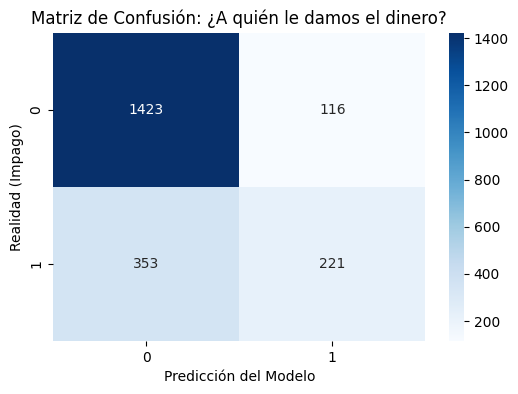

In [7]:
cm = confusion_matrix(y_test, predicciones)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad (Impago)')
plt.title('Matriz de Confusión: ¿A quién le damos el dinero?')
plt.show()

<Axes: title={'center': 'Importancia de Variables'}, xlabel='Variable'>

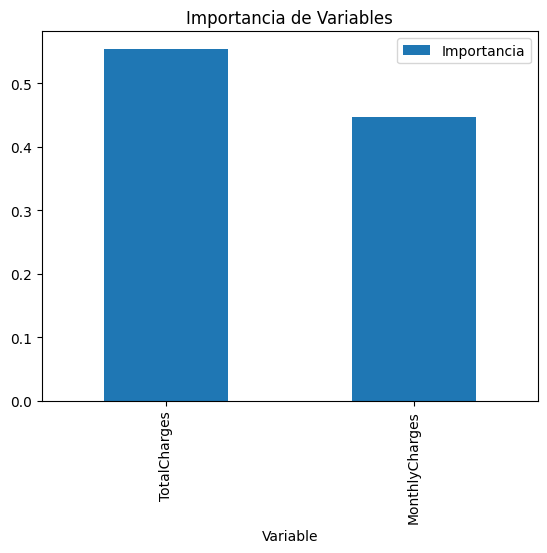

In [8]:
importancia = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo_tree.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancia.set_index('Variable').plot(kind='bar',title='Importancia de Variables')


## **Documentación de Reglas**

In [35]:
def extraer_reglas_arbol(modelo_arbol, nombres_features, nombres_clases):
    """
    Extrae reglas de negocio comprensibles de un árbol de decisión
    """
    from sklearn.tree import _tree

    tree_ = modelo_arbol.tree_
    feature_names = nombres_features

    reglas = []

    def recorrer_nodo(nodo_id, regla_actual):
        # Si es hoja
        if tree_.feature[nodo_id] == _tree.TREE_UNDEFINED:
            clase = nombres_clases[tree_.value[nodo_id].argmax()]
            muestras = tree_.n_node_samples[nodo_id]
            reglas.append({
                'regla': regla_actual,
                'clase': clase,
                'muestras': int(muestras),
                'confianza': tree_.value[nodo_id].max() if tree_.value[nodo_id].argmax() == 0 else 1 - tree_.value[nodo_id].max()
            })
            return

        # Si no es hoja
        feature = feature_names[tree_.feature[nodo_id]]
        threshold = tree_.threshold[nodo_id]

        # Rama izquierda (<=)
        nueva_regla = f"{regla_actual} Y {feature} <= {threshold:.2f}"
        recorrer_nodo(tree_.children_left[nodo_id], nueva_regla)

        # Rama derecha (>)
        nueva_regla = f"{regla_actual} Y {feature} > {threshold:.2f}"
        recorrer_nodo(tree_.children_right[nodo_id], nueva_regla)

    recorrer_nodo(0, "SI")

    # Ordenar por número de muestras
    reglas.sort(key=lambda x: x['muestras'], reverse=True)

    print("📋 REGLAS DE NEGOCIO EXTRAÍDAS:")
    print("=" * 60)
    for i, regla in enumerate(reglas[:8]):  # Mostrar solo top 8
        print(f"\nRegla #{i+1}:")
        print(f"Condición: SI {regla['regla'][4:]}")
        print(f"Decisión: {regla['clase']}")
        print(f"Casos: {regla['muestras']:,}")
        print(f"Confianza: {regla['confianza']:.1%}")

    return reglas

In [36]:
reglas = extraer_reglas_arbol(modelo_tree, X.columns, ['Se Queda', 'Fuga'])

📋 REGLAS DE NEGOCIO EXTRAÍDAS:

Regla #1:
Condición: SI  MonthlyCharges > 27.68 Y TotalCharges > 1270.68 Y MonthlyCharges > 73.62
Decisión: Se Queda
Casos: 1,753
Confianza: 76.5%

Regla #2:
Condición: SI  MonthlyCharges > 27.68 Y TotalCharges <= 1270.68 Y MonthlyCharges > 68.60
Decisión: Fuga
Casos: 756
Confianza: 34.4%

Regla #3:
Condición: SI  MonthlyCharges <= 27.68 Y TotalCharges > 146.45 Y TotalCharges <= 1334.60
Decisión: Se Queda
Casos: 680
Confianza: 95.6%

Regla #4:
Condición: SI  MonthlyCharges > 27.68 Y TotalCharges > 1270.68 Y MonthlyCharges <= 73.62
Decisión: Se Queda
Casos: 664
Confianza: 90.7%

Regla #5:
Condición: SI  MonthlyCharges > 27.68 Y TotalCharges <= 1270.68 Y MonthlyCharges <= 68.60
Decisión: Se Queda
Casos: 629
Confianza: 65.0%

Regla #6:
Condición: SI  MonthlyCharges <= 27.68 Y TotalCharges > 146.45 Y TotalCharges > 1334.60
Decisión: Se Queda
Casos: 174
Confianza: 100.0%

Regla #7:
Condición: SI  MonthlyCharges <= 27.68 Y TotalCharges <= 146.45 Y TotalCharges